In [21]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [6]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

In [7]:
y_train = train["y"]
x_train = train.drop(["y"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [11]:
x_test = test.copy()

for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
x_test = x_test.astype(np.float32)

In [13]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [14]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [15]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:95.968	test-rmse:95.9667
[50]	train-rmse:10.9934	test-rmse:11.1884
[100]	train-rmse:7.48883	test-rmse:8.39515


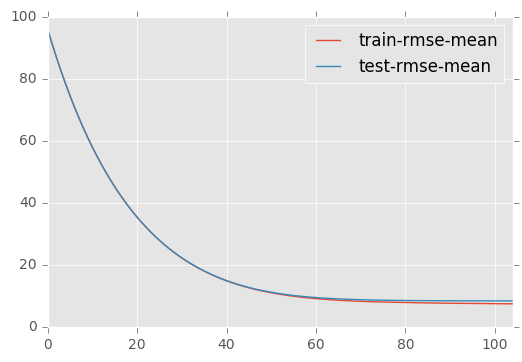

In [16]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [17]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

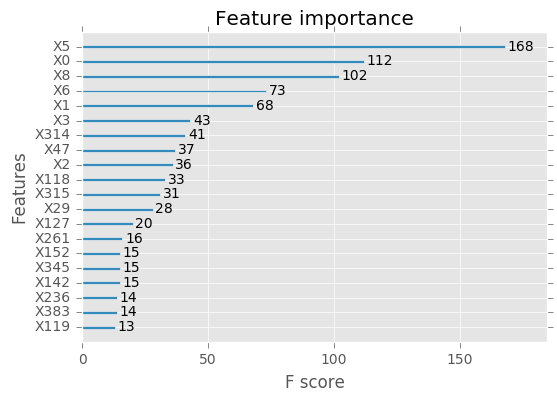

In [18]:
xgb.plot_importance(model, max_num_features=20)

In [22]:
y_pred = model.predict(dtrain)

In [23]:
r2_score(y_train, y_pred)

0.63256989950379339

### Prediction

In [29]:
y_predict = model.predict(dtest)

In [30]:
output = pd.DataFrame({"ID": x_test.index, "y": y_predict})

In [32]:
output.head()

,ID,y
0,1,81.746040
1,2,98.966293
2,3,82.673309
3,4,77.018295
4,5,109.772110


In [33]:
output.to_csv("submissions_{}.csv".format(datetime.datetime.today()), index=False)